<h1><center>Wrangling Openstreetmap</center></h1>

## Map Area
***
For this project, I chose to use my home county of Snohomish County in Washington State, USA as well as some of the surrounding counties (Latitude of -122.7530 to -120.5969 and longitude of 48.4429 to 47.6302). I felt using a place I know would make finding problems with the data easier to spot. 

## Problems Encountered
***
After converting the OSM file to CSV files and then importing the CSVs to a SQLITE3 database, I ran this:

***
```python
import sqlite3
import os
conn = sqlite3.connect('final_county.sqlite')
c = conn.cursor()

c.execute("""
SELECT value, key, COUNT(*) 
FROM new_nodes_tags 
GROUP BY value, key 
ORDER BY key COLLATE NOCASE, value COLLATE NOCASE;""")
for f in c.fetchall():
    print f
```
***

and

***
```python
c.execute("""
SELECT value, key, COUNT(*) 
FROM new_ways_tags 
GROUP BY value, key 
ORDER BY key COLLATE NOCASE, value COLLATE NOCASE;""")
for f in c.fetchall():
    print f
```
***

Scanning through the data, I found several problems. Some that I can fix by running some code, some that would require fixing value by value.

Keys that needed to be standardized:
- "state_code", "ST_alph" and "ST_alpha" shouldn't be different keys.
- "state_id" and "STATEFP" shouldn't be different keys.
- "postal_code" and "postcode" shouldn't be different keys.
- "County_num" and "COUNTYFP" shouldn't be different keys.
- "elevation" and "Elevation" shouldn't be different keys.
- "owner", "OWNER" and "Owner" shouldn't be different keys.
- "county", "county_name" and "County" shouldn't be different keys.

Values that needed to be standardized and have their spelling fixed:
- Different spellings and formats to city names. Ex: 'Bothel' should be spelled 'Bothell'. Or 'Edmonds, WA' should be just 'Edmonds'.
- Different spellings and formats to county names. Ex: 'Chelan, WA' should be just 'Chelan'.
- Different spellings and formats to the state's name.
- The value for the key "country" is sometimes "us" and other times "usa".
- Postal codes should also be standardized.

Other things to fix:
- Data that has a ';' should be split into new key, value rows.

### Keys

Using the following code, I standardized keys that I felt needed to be the same key.

***
```python
replace = {'County': 'county', 'FIXME': 'fixme', 'Elevation': 'elevation', 'fixeme': 'fixme', 'ST_alph': 'ST_alpha', 
           'COUNTYFP': 'County_num', 'postcode': 'postal_code', 'county_name': 'county', 'state_id': 'ST_num', 
           'state_code': 'ST_alpha', 'STATEFP': 'ST_num'}
def replace_keys(old_key):
    if old_key in replace:
        return replace[old_key]
    else:
        return old_key
```
***

### Values (Cities, Counties, State, Country)

I first created a dictionary of the proper spellings of city, town, county, state, and country names. The county and city/town names I got from the American Government's census website.  
City/Town List: https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2010_place_list_53.txt  
County List: http://www2.census.gov/geo/docs/maps-data/data/gazetteer/counties_list_53.txt
  
  
The following is an example of the lists I made using the census data. The true lists are much longer.

***
```python
city = "Aberdeen,Aberdeen Gardens,Acme,Addy,Ahtanum,Airway Heights,Albion,Alder,Alderton,Alderwood".split(',')
city = {'city':city}
county = 'Adams,Asotin,Benton,Chelan,Clallam,Clark,Columbia,Cowlitz,Douglas,Ferry,Franklin,Garfield'.split(',')
county = {'county':county}

state = {'state':['State of Washington']}

country = {'country':['CZ', 'CY', 'KH', 'SE','PE', 'USA']}

source = {'city':city,'county':county,'state':state,'country':country}

common_mistakes = {'city':{},'county':{},'state':{},'country':{}}
to_check = {'city':{},'county':{},'state':{},'country':{}}
```
***

I would then run the following code to check for any value that does not appear in the corresponding list. For example, it will look at a row of data. It will see that the key is 'county' and the value is 'Garfeld'. It would look in the county list for 'Garfeld' and not find it. So it will then check the common_mistakes list for 'Garfeld'. If it is there, it will change the value to the proper spelling or format. If not there it will place 'Garfeld' in the to_check list.

***
```python
def format_and_spelling(value, correct, place, to_check, common_mistakes):
    if value in correct[place]:
        return value
    elif ',' in value:
        split_val = value.split(',')
        if len(split_val) == 2:
            if value not in common_mistakes[place].keys():
                common_mistakes[place][value] = format_and_spelling(split_val[0], correct, place, to_check, common_mistakes)
        else:
            if value not in common_mistakes[place].keys():
                if value not in to_check[place].keys():
                    to_check[place][value] = ''
            elif value in common_mistakes[place].keys():
                return format_and_spelling(common_mistakes[place][value], 
                                           correct, place, to_check, common_mistakes)
    else:
        if value not in common_mistakes[place].keys():
            if value not in to_check[place].keys():
                to_check[place][value] = ''
        elif value in common_mistakes[place].keys():
            return format_and_spelling(common_mistakes[place][value], 
                                       correct, place, to_check, common_mistakes)

conn.commit()

def fix_mistakes(c, table, key, source):
    c.execute("""
    SELECT * 
    FROM {table}
    WHERE key='{key}';""".format(table=table, key=key))
    for f in c.fetchall():
        value = format_and_spelling(f[2], source[key], key, to_check, common_mistakes)

for key in common_mistakes.keys():
    fix_mistakes(c, 'new_nodes_tags', key, source)
    fix_mistakes(c, 'new_ways_tags', key, source)
        
conn.commit()
```
***

Once all the values have been checked, I go through the to_check list and place the misspelled and misformatted values in the common_mistakes dictionary with the mistake being the key and the proper spelling or format being the value. (EX: {'city':{'Kirkalnd': 'Kirkland', 'Tulalip': 'Tulalip Indian Reservation'}}) Once that is finished I run the following code to fix the spelling and formating of the values.

```python
common_mistakes = {'city':
                   {'Kirkalnd': 'Kirkland', 'Tulalip': 'Tulalip Indian Reservation', 'kenmore': 'Kenmore', 
                    'Port Gamble': 'Port Gamble Tribal Comunity', 'EDMONDS': 'Edmonds', 'Granite Fall': 'Granite Falls', 
                    'seattle': 'Seattle', 'BOTHELL': 'Bothell', 'Remond': 'Redmond', 'SILVERDALE': 'Silverdale', 
                    'Greenbank (Whidbey Island)': 'Greenbank', 'everett': 'Everett', 'goldbar': 'Gold Bar', 
                    'Oak Harbor (Whidbey Island)': 'Oak Harbor', 'marysville': 'Marysville', 'Lynwood': 'Lynnwood', 
                    'Woodenville': 'Woodinville', 'Camano Island': 'Camano', 'coupeville': 'Coupeville', 
                    'EVERETT': 'Everett', 'leavenworth': 'Leavenworth', 'Lake Stephens': 'Lake Stevens', 
                    'Mt. Vernon': 'Mount Vernon', 'Coupeville (Whidbey Island)': 'Coupeville', 'Bothel': 
                    'Bothell', 'woodinville': 'Woodinville'},
                   'county':
                   {'King, WA:Snohomish, WA': 'King;Snohomish', 'King, WA;Chelan, WA': 'King;Chelan'},
                   'state':
                   {'wa': 'State of Washington', 'w': 'State of Washington', 'Wa': 'State of Washington', 
                    '98107': 'State of Washington', 'Washington': 'State of Washington', 'W': 'State of Washington', 
                    'WA': 'State of Washington'},
                   'country':
                   {'US': 'USA'}}

def fix_values(key, old_value):
    if old_value in common_mistakes[key]:
        return common_mistakes[key][old_value]
    else:
        return old_value
```

### Values (Postal Codes)
Postal codes had several problems. The code is not located in the area I am looking at. Or the postal_code value is not a postal code. Or it is not in the standard 5 digit number format.

The following code I used would look if there was a '-' in it and then would split it at the '-'. Then would replace the old value with a new one that consisted of any data before the '-'.
***
```python
def fix_post(old_value):
    if '-' in old_value:
        return old_value.split('-')[0]
    else:
        return old_value
```
***
The remaining data that needed to be fix was few enough that it was quicker to fix by hand. Here is a table of what I fixed.



| Table          | changed data    | id         | key         | value                    | type |
|-|-|-|-|-|-|
| new_nodes_tags | old key         | 2330164753 | **postal_code** | 16518                    | addr |
| new_nodes_tags | corrected key   | 2330164753 | **housenumber **| 16518                    | addr |
| new_nodes_tags | old key         | 1154547678 | **postal_code** | 9322                     | addr |
| new_nodes_tags | corrected key   | 1154547678 | **housenumber **| 9322                     | addr |
| new_nodes_tags | old key         | 1097345357 | **postal_code **| W Lake Sammamish Pkwy NE | addr |
| new_nodes_tags | corrected key   | 1097345357 | **street      **| W Lake Sammamish Pkwy NE | addr |
| new_ways_tags  | old key         | 238863424  | **postal_code** | Stevens Pass Highway     | addr |
| new_ways_tags  | corrected key   | 238863424  | **street     ** | Stevens Pass Highway     | addr |
| new_ways_tags  | old key         | 238863424  | **street     ** | 98288                    | addr |
| new_ways_tags  | corrected key   | 238863424  | **postal_code **| 98288                    | addr |
| new_ways_tags  | old key         | 223469578  | **postal_code **| WA                       | addr |
| new_ways_tags  | corrected key   | 223469578  | **ST_alpha    **| WA                       | addr |
| new_ways_tags  | old key         | 284564183  | **postal_code **| WA                       | addr |
| new_ways_tags  | corrected key   | 284564183  | **ST_alpha   ** | WA                       | addr |
| new_nodes_tags | old value       | 2991868882 | postal_code |** WA 98203                 **| addr |
| new_nodes_tags | corrected value | 2991868882 | postal_code | **98203                  **  | addr |
| new_nodes_tags | old value       | 2991879246 | postal_code | **WA 98260             **    | addr |
| new_nodes_tags | corrected value | 2991879246 | postal_code | **98260                **    | addr |
| new_nodes_tags | old value       | 4450814996 | postal_code | **98936              **      | addr |
| new_nodes_tags | corrected value | 4450814996 | postal_code | **98036            **        | addr |
| new_nodes_tags | old value       | 2922199666 | postal_code | **89370          **          | addr |
| new_nodes_tags | corrected value | 2922199666 | postal_code | **98346        **            | addr |
| new_ways_tags  | old value       | 367269744  | postal_code | **97277      **              | addr |
| new_ways_tags  | corrected value | 367269744  | postal_code | **98277    **                | addr |
| new_ways_tags  | old value       | 531146635  | postal_code | **99163  **                  | addr |
| new_ways_tags  | corrected value | 531146635  | postal_code | **98253**                    | addr |

## Data Overview
***
##### File Sizes
Files|Size
---|
Snohomish_County.osm|684 MB
nodes.csv|259 MB
nodes_tags.csv|16.2 MB
ways.csv|21.2 MB
ways_nodes.csv|84.0 MB
ways_tags.csv|49.6 MB
new_nodes.csv|256 MB
new_nodes_tags.csv|15.8 MB
new_ways.csv|20.9 MB
new_ways_nodes.csv|80.6 MB
new_ways_tags.csv|48.2 MB
final_county.sqlite|509 MB

##### Unique Users
By using the following code I get 2037 unique users.
***
```python
c.execute("""
SELECT COUNT(DISTINCT(u.uid))
FROM (SELECT uid
FROM new_nodes n
UNION ALL
SELECT uid
FROM new_ways w
GROUP BY uid) u;""")
print c.fetchall()
```
***

##### Number of Posts by Each User
The number of posts made by each user is not evenly spread. Instead most of the posts are made by a small (small meaning in the hundreds) group of users. This is easier to see if plotted out.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sqlite3
import os
conn = sqlite3.connect('final_county.sqlite')
c = conn.cursor()
plt.style.use('seaborn-white')

active_users = []
c.execute("""
SELECT COUNT(*)
FROM
(SELECT uid
FROM new_nodes
UNION ALL
SELECT uid
FROM new_ways) u
GROUP BY u.uid
ORDER BY COUNT(*)
DESC;""")
for v in c.fetchall():
    active_users.append(int(v[0]))

mpl.rcParams['figure.figsize'] = [12.0, 10.0]

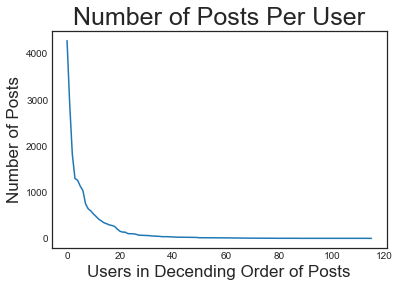

In [2]:
plt.title('Number of Posts Per User', fontsize=25)
plt.ylabel('Number of Posts', fontsize=17)
plt.xlabel('Users in Decending Order of Posts', fontsize=17)
plt.plot(active_users);

Even if you remove the top 100 users, the drop is still relatively steep.

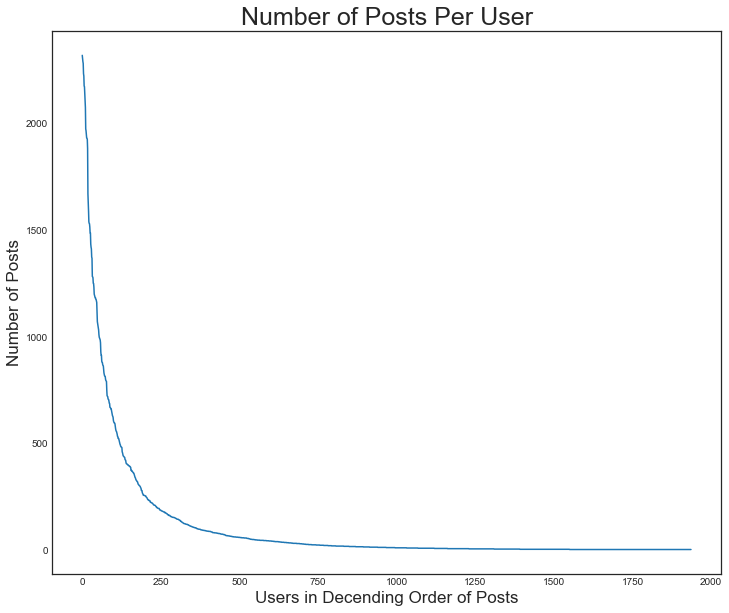

In [3]:
plt.title('Number of Posts Per User', fontsize=25)
plt.ylabel('Number of Posts', fontsize=17)
plt.xlabel('Users in Decending Order of Posts', fontsize=17)
plt.plot(active_users[100:]);

To be this prevalent, it is very likely that the top users are bots. In future studies it would be interesting to see what percentage of mistakes are made by bots vs. human users.

##### Other Interesting Information
Using the following code (replace &#60;key_name&#62; with the key that you want to use), I looked at lists of values for various keys that I thought could show some interesting information.

```python
c.execute("""
SELECT c.value, COUNT(*)
FROM (SELECT * FROM new_nodes_tags
UNION ALL
SELECT * FROM new_ways_tags) AS c
WHERE c.key = '<key_name>'
GROUP BY c.value
ORDER BY COUNT(*)
DESC;
""")
for f in c.fetchall():
    print f[0], '|',f[1]
```

<p style="text-align: center;"> **Top Ten Values for the 'city' Key** </p>

value | count
-|-
Seattle | 111965
Kirkland | 42241
Mount Vernon | 11071
Redmond | 2783
Mill Creek | 969
Kingston | 608
Edmonds | 594
Woodinville | 269
Bothell | 264
Lynnwood | 201

Despite the openstreetmap sample I took only covering the upper half of Seattle, there are 51,488 more values that are 'Seattle' than all other towns, cities, census areas combined.

---

<p style="text-align: center;"> **Top Ten Values for the 'county' Key** </p>

value | count
-|-
Snohomish | 18070
King | 16957
Kitsap | 4088
Skagit | 2010
Jefferson | 778
Chelan | 715
Island | 530
King;Snohomish | 17
King;Chelan | 1
Kittitas | 1

Despite the openstreetmap sample I took only covering less than 1/3 of King County, the number of keys that are 'King' (16,957) are very close to the number of keys are 'Snohomish' (18,070).


---

<p style="text-align: center;"> **Top Values for the 'religion' Key** </p>

value | count
-|-
christian | 466
jewish | 11
buddhist | 6
muslim | 4
unitarian_universalist | 2
bahai | 1
hindu | 1
new_thought | 1
none | 1
religious_science | 1
shinto | 1
sikh | 1

For a very Caucasian area, it is not surprising that there are a large number of Christians. For some, seeing 'shinto' on this list could be surprising. There are only 2 Shinto shrines on the mainland USA.


---

<p style="text-align: center;"> **Top Values for the 'artwork type' Key** </p>

value | count
-|-
sculpture | 137
mural | 10
statue | 10
architecture | 3
Changing_Workplace,_Yesterday,_Today,_Tomorrow | 1
deck | 1
dome | 1
interactive | 1

Sculptures are more prevalent than I would expect.


---

<p style="text-align: center;"> **Top Ten Values for the 'natural' Key** </p>

value | count
-|-
water | 2110
tree | 1220
wood | 888
wetland | 631
coastline | 429
sand | 405
peak | 352
glacier | 175
beach | 128
scrub | 110

---

<p style="text-align: center;"> **Top Ten Values for the 'shop' Key** </p>

value | count
-|-
convenience | 366
hairdresser | 285
beauty | 259
car_repair | 258
supermarket | 221
clothes | 211
yes | 157
car | 116
dry_cleaning | 94
furniture | 87

---

<p style="text-align: center;"> **Top Ten Values for the 'leisure' Key** </p>

value | count
-|-
pitch | 1702
park | 879
playground | 655
picnic_table | 303
swimming_pool | 259
fitness_centre | 144
garden | 121
slipway | 115
sports_centre | 95
golf_course | 61

---

<p style="text-align: center;"> **Top Ten Values for the 'type' Key** </p>

value | count
-|-
pile | 2223
communication | 90
downhill | 55
sign | 51
pillar | 31
lighting | 22
small_craft_facility | 16
wreck | 16
separation_lane | 12
buoy_lateral | 11

---

<p style="text-align: center;"> **Top Ten Values for the 'cuisine' Key** </p>

value | count
-|-
coffee_shop | 271
burger | 189
pizza | 183
mexican | 174
sandwich | 133
american | 106
thai | 86
chinese | 72
italian | 59
asian | 49

---

<p style="text-align: center;"> **Top Ten Values for the 'sport' Key** </p>

value | count
-|-
baseball | 443
tennis | 440
basketball | 229
soccer | 218
golf | 141
american_football | 61
swimming | 54
skateboard | 28
multi | 26
yoga | 24

---

<p style="text-align: center;"> **Top Ten Values for the 'tourism' Key** </p>

value | count
-|-
artwork | 289
information | 237
camp_site | 192
picnic_site | 112
viewpoint | 106
hotel | 97
attraction | 81
motel | 41
museum | 25
guest_house | 14

---

<p style="text-align: center;"> **Top Ten Values for the 'opening hours' Key** </p>

value | count
-|-
24/7 | 156
Mo-Sa 10:00-21:00 | 13
Mo-Fr 08:00-17:00 | 10
Mo-Fr 08:00-18:00 | 9
11:00-21:00 | 8
Mo-Fr 07:00-22:00 | 8
Mo-Fr 09:00-17:00 | 8
Mo-Sa 10:00-19:00 | 8
Mo-Fr 08:00-18:00; Sa 08:00-17:00 | 7
Mo-Su 08:00-20:00 | 7

---

<p style="text-align: center;"> **Top Ten Values for the 'fixme' Key** </p>

value | count
-|-
continue | 61
name?? | 61
is the correct maxspeed 25 mph (40 km/h) or 40 mph? | 58
Missing addresses | 27
name??? | 24
draw more precisely | 22
position | 17
What route is this? Convert to relation | 16
bad address range | 15
resurvey | 15

---

<p style="text-align: center;"> **Top Ten Values for the 'denomination' Key** </p>

value | count
-|-
lutheran | 60
baptist | 32
methodist | 26
presbyterian | 24
mormon | 21
catholic | 19
jehovahs_witness | 10
episcopal | 8
nazarene | 8
roman_catholic | 8

---

<p style="text-align: center;"> **Top Ten Values for the 'artist name' Key** </p>

value | count
-|-
Perri Lynch | 9
Richard Beyer | 7
Beliz Brother | 3
Bruce Myers | 3
Charles Greening | 3
Dan Ostermiller | 3
George Tsutakawa | 3
John Hoge | 3
Mark Lere | 3
Richard Spaulding | 3

---


## Other Possible Improvements
Given more time, there were several more things that I or someone else could possibly have done to improve this data.

##### Phone Numbers
The formatting of the phone numbers is all over the place. You just need to look at the first ten phone numbers in the new_ways_tags table to see the problem. If you enter this code:

```python
c.execute("""
SELECT value
FROM new_ways_tags t
WHERE key = 'phone'
LIMIT 10;""")
for n in c.fetchall():
    print n[0]
```
 You get the following phone numbers that follow the corrisponding formats:
 
 value|format
 -|-
+1-206-5482500|+x-xxx-xxxxxxx
(425) 482-1111|(xxx) xxx-xxxx
425-488-4444|xxx-xxx-xxxx
+1 360 657 5762|+x xxx xxx xxxx
+1-360-716-6000|+x-xxx-xxx-xxxx
(425) 865-0210|(xxx) xxx-xxxx
425 936-2500|xxx xxx-xxxx
425 746-0506|xxx xxx-xxxx
425-746-1084|xxx-xxx-xxxx
(425) 649-0791|(xxx) xxx-xxxx

Just in the first ten phone numbers, there are 6 phone number formats used:

(xxx) xxx-xxxx
+x xxx xxx xxxx
+x-xxx-xxxxxxx
+x-xxx-xxx-xxxx
xxx xxx-xxxx
xxx-xxx-xxxx


In the entire new_ways_tags table, there are 31 phone number formats used. Fifteen of which are used more than once. Here are the top fifteen formats:

phone number format|number of times used
-|-
+x-xxx-xxx-xxxx|151
+x xxx xxx-xxxx|72
xxx-xxx-xxxx|62
(xxx) xxx-xxxx|58
+x xxx-xxx-xxxx|51
+x xxx xxx xxxx|44
+x-xxx-xxxxxxx|41
+xxxxxxxxxxx|21
xxxxxxxxxx|13
xxx xxx xxxx|9
+x xxx xxxxxxx|8
xxx.xxx.xxxx|8
xxxxxxxxxxx|6
+x (xxx) xxx-xxxx|5
(xxx)xxx-xxxx|4

##### Replace Values with a Comma that Should be a Semicolon
There are some values that use a comma to separate values that should be separated by a semicolon. But it is not as simple as replaceing all values' commas with semicolons. 

```python
c.execute("""
SELECT key, COUNT(*), value
FROM new_nodes_tags
WHERE value LIKE '%,%'
GROUP BY key
ORDER BY COUNT(*)
DESC
LIMIT 20;""")
for n in c.fetchall():
    n
```

key|number of values using commas|example value
-|-|-
attribution | 1011 | City of Seattle, Department of Transportation, Traffic Management, Bicycle Program
is_in | 269 | Washington,Wash.,WA,USA
description | 75 | Located on the third floor, near the elevator and the assistant principal office
name | 61 | Cornerstone Roofing, Inc.
opening_hours | 59 | 09:00-13:00,16:00-20:30
opening_hours_1 | 48 |  Sat, Sun 12-5 M-W Closed Summer M Closed, T-Th 10-5m Fr-Sun 11-4
media | 47 | Ceramic tile, stoneware
note | 28 | The stand is located at the Bothell Library. The hand air pump does not have a pressure gauge attached. The stand is also missing a tool, as evidenced by tool cable with a missing and frayed end.
location | 26 | Park - Bitter Lake Park, east side
wikipedia | 25 | en:Eastlake, Seattle
opening_hours_2 | 12 |  We,Fr 09:00-13:00,15:00-18:00
fixme | 7 | Correct building, location in building approximate
source | 7 | Local knowledge, official website 
cuisine | 6 | teriyaki,_asian
measurements | 6 | 70 pieces: 37 pieces at 15h x 15w, 20 pieces at 23 & 15w, 13 pieces at 31h x 15w. All pieces are 1d. Series of clear glass panels.
collection_times | 5 | Mo-Fr 10:15,16:00
street | 5 | Hewitt Ave, Everett
collection_times_1 | 4 |  Sa 10:15,14:00
inscription | 4 | In sacred remembrance to the comrades of the Illinois soldiers, sailors and marines who served in the Spanish-American War.
opening_hours_3 | 4 |  Th,Fr 08:00-17:00

If you look at this table, you can see that not all values are using commas to separate values in the sense of how the semicolon is used in Openstreetmap. So something like 'cuisine' and 'opening_hours' should have its comma replaced with a semicolon, while something like 'description' is using it just like a normal comma in a sentence. So replaceing them would be a process of understanding the comma's usage in the value.

##### Standardize the Formatting and Spelling of Address Parts
When looking at these tables:

```python
c.execute("""
SELECT key, value
FROM new_nodes_tags
WHERE key = 'address'
LIMIT 10;""")
for n in c.fetchall():
    print n
```

key|value
-|-
address | 2101 N Northlake Wy
address | N 34th St & Fremont Ave N
address | 12518 Lake City Way Northeast
address | 2300 Arboretum Dr E
address | 5500 Phinney Ave N
address | 7600 Sand Point Wy NE Unknown
address | Burke-Gilman Trail underneath University Bridge
address | NE 40th St & NE Pacific St
address | Northlake Ave & 4th Ave NE
address | 1400 E Galer St

```python
c.execute("""
SELECT key, value
FROM new_nodes_tags
WHERE key = 'street'
LIMIT 25;""")
i=0
for n in c.fetchall():
    if i > 13:
        print n
    i += 1
```

key|value
-|-
street | Northeast 24th Street
street | Northeast 24th Street
street | Northeast 24th Street
street | Northeast 24th Street
street | Northeast 24th Street
street | NE 24th St
street | NE 24th St
street | 152 Ave NE
street | NE 24th St
street | NE 24th St
street | 25th Ave NE

As an example, in both tables, you can see that Northeast is written as both 'Northeast' and 'NE'. This is just one example of many inconcisstancies in street name formatting.

##### Spliting Values with Semicolons

In just the new_ways_tags table, there are 81,055 values containing semicolons. If we look at examples of values with semicolons from each type of key (see below), if the examples are good representatives of the rest of the values, only values from the 'note' key and the 'description' key should be ignored.

```python
c.execute("""
SELECT key, COUNT(*), value
FROM new_ways_tags
WHERE value LIKE '%;%'
GROUP BY key
ORDER BY COUNT(*)
DESC;""")
for n in c.fetchall():
    print n
```

key|count|value
-|-|-
source | 79073 | King County GIS;data.seattle.gov
old_ref | 727 | WA 527;PSH 2-BE (Old US 99;SR 1)
name_base | 182 | Pine; Grove
opening_hours | 135 | Su-Th 06:00-22:00; Fr-Sa 06:00-24:00
lanes:forward | 134 | left;through&#124;right
destination | 113 | Bothell;Lake City Way
lanes | 105 | through&#124;through;right
lanes:backward | 91 | left;through&#124;right
cfcc | 77 | A41;A41;A51
name_type | 65 | Ave;Dr
crossing | 59 | uncontrolled;zebra
unit | 39 | 31;32
cuisine | 26 | breakfast;burger;sandwich
sport | 25 | tennis;swimming;racquetball
street | 24 | Bellevue Way Northeast;Lake Washington Boulevard Northeast
surface | 19 | dirt;grass
county | 18 | King;Snohomish
housenumber | 15 | 8500;85000
name_base_1 | 15 | State Route 9; State Route 9; State Highway 9; State Route 9
ref | 13 | US 2 West;US 2 East
name_direction_suffix | 12 | W; SW
reviewed | 11 | no;aerial
directions | 8 | WA 522 N;Bothell;Lake City Way NE
note | 8 | this is just a small segment of the actual stream; needs to be expanded; see http://www.ci.bellevue.wa.us/pdf/Parks/trail_map_ardmore.pdf
is_in | 7 | Lacey; Washington; USA
bicycle | 4 | no;yes
position | 4 | seated;urinal
feature_id | 3 | 1532436;1532435
fixme | 3 | This is actually the eastbound onramp from streets near marina; needs survey
forward | 3 | Northeast 103rd Street;1st Avenue Northeast
name_direction_prefix | 3 | W; E
ref:to | 3 | I 5;WA 527
width | 3 | 2;3
conditional | 2 | yes @ (12:00-04:00);-1 @ (04:00-12:00)
name | 2 | Ebey Waterfront Trail;
name_1 | 2 | Northeast 155th Street; Arrowhead Drive
plant | 2 | tree;shrub
tlid | 2 | 183649109; 183670791:183672250:183672251
voltage | 2 | 230000;115000
alt_name | 1 | Ebey Island Road;52nd Street Southeast
backward | 1 | Bothell;Lake City Way
cargo | 1 | passengers;vehicle
collection_times | 1 | Mo-Fr 17:00;Sa 14:15
crop | 1 | corn;pumpkin
description | 1 | The Activities & Recreation Center (ARC) is the hub of student life on campus; a place for students to gather, socialize, dine, and exercise. Featuring three floors of student resources and amenities.
footway | 1 | sidewalk; crossing; sidewalk
for | 1 | child;juvenile;family
internet_access | 1 | wlan;terminal
media | 1 | High-tensile steel fused to syntactic foam; carboline mb 133 satin black paint; concrete
name_type_1 | 1 | Ct; St
phone | 1 | +1 360 678-4097;+1 800 366-4097
ref:lanes | 1 | WA 99 South;WA 527&#124;WA 526 West
reverse | 1 | Mo-Fr 05:00-11:00;Sa-Su 07:00-13:30
short_name | 1 | 194th PL NE; NE 65th WY
water | 1 | lake;pond



This is more subjective, but splitting values with a ';' and its corresponding key into multiple key, value pairs might be cleaner than dumping all the various opening hours into one value. For example, instead of:

```python
c.execute("""
SELECT key, value
FROM new_ways_tags
WHERE value LIKE '%;%'
AND key = 'cuisine'
LIMIT 1;""")
for n in c.fetchall():
    print n
```

id|key|value|type
-|-|-|-
29465694 | cuisine | american;breakfast | regular

You would have this:

id|key|value|type
-|-|-|-
29465694 | cuisine | american | regular
29465694 | cuisine_1 | breakfast | regular

Or instead of this:

```python
c.execute("""
SELECT key, value
FROM new_ways_tags
WHERE value LIKE '%;%'
AND key = 'opening_hours'
LIMIT 1;""")
for n in c.fetchall():
    print n
```

id|key|value|type
-|-|-|-
29362438 | opening_hours | Mo-Th 11:00-22:00; Fr 11:00-23:00; Sa 12:00-23:00; Su 12:00-22:00 | regular

You would have this:

id|key|value|type
-|-|-|-
29362438|opening_hours_Mon|11:00-22:00|regular
29362438|opening_hours_Tues|11:00-22:00|regular
29362438|opening_hours_Wed|11:00-22:00|regular
29362438|opening_hours_Thur|11:00-22:00|regular
29362438|opening_hours_Fri|11:00-23:00|regular
29362438|opening_hours_Sat|12:00-23:00|regular
29362438|opening_hours_Sun|12:00-22:00|regular


---

## Conclusion
There many problems with the data. From misspellings to various formatting styles to just outright incorrect data. This is a problem with all forms of crowdsourcing. Given time, perhaps the more prolific users (aka bots) will become better as machine learning and AI becomes more advanced. In the meantime, volunteer drives, donation drives, incentivisation and having volunteer editors could possibly help improve the amount and quality of data. Having some way to have at least two, if not three or four, people look at the same data to make sure it meets some standard could greatly improve the quality of the overall data. In the end, correcting, updating, and expanding Openstreetmap's data will be a never-ending uphill battle. But that does not mean it should not be done.

***